In [2]:
from typing_extensions import TypedDict

class State(TypedDict):
    """
    A class representing a state with a name and a value.
    """
    name: str
    value: str

In [4]:
from langgraph.graph import StateGraph, START, END
from typing_extensions import TypedDict
from pydantic import BaseModel

class OverallState(BaseModel):
    a:str

In [8]:
def node(state: OverallState):
    
    return {"a":"Hi I am Aman"}

builder  = StateGraph(OverallState)
builder.add_node(node)
builder.add_edge(START, "node")
builder.add_edge("node", END)
graph = builder.compile()

In [9]:
graph.invoke({"a":"Hello"})

{'a': 'Hi I am Aman'}

In [13]:
try:
    graph.invoke({"a":123})
except Exception as e:
    print("Exception was raised because the input was not a string")


## Multiple Nodes- Run time validation

Run-time validation will also work in a multi-node graph. In the example below bad_node updates a to an integer.

Because run-time validation occurs on inputs, the validation error will occur when ok_node is called (not when bad_node returns an update to the state which is inconsistent with the schema).

In [18]:
from langgraph.graph import StateGraph, START, END
from typing_extensions import TypedDict
from pydantic import BaseModel

class OverallState(BaseModel):
    a:str
    
def bad_node(state: OverallState):
    return {"a":123}  # This should be a string, but it's an int

def ok_node(state: OverallState):
    return {"a":"Goodbye"}  # This is a valid string

builder = StateGraph(OverallState)
builder.add_node(bad_node)
builder.add_node(ok_node)
builder.add_edge(START, "bad_node")
builder.add_edge("bad_node", "ok_node")
builder.add_edge("ok_node", END)
graph = builder.compile()

In [19]:
graph.invoke({"a":"Aman"})  

{'a': 'Goodbye'}

In [20]:
try:
    graph.invoke({"a": "krish"})
except Exception as e:
    print("An exception was raised because bad_node sets `a` to an integer.")
    print(e)

### Prompt Chaining
Prompt chaining decomposes a task into a sequence of steps, where each LLM call processes the output of the previous one. You can add programmatic checks on any intermediate steps to ensure that the process is still on track.

When to use this workflow: This workflow is ideal for situations where the task can be easily and cleanly decomposed into fixed subtasks. The main goal is to trade off latency for higher accuracy, by making each LLM call an easier task.

![WhatsApp Image 2025-05-17 at 16.17.12_8430e0a2.jpg](<attachment:WhatsApp Image 2025-05-17 at 16.17.12_8430e0a2.jpg>)
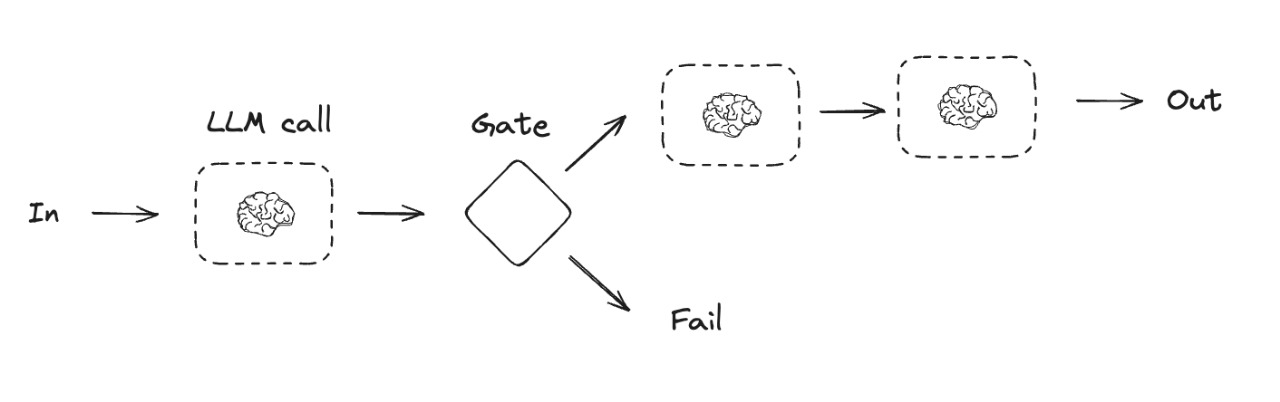

In [24]:
import os
from dotenv import load_dotenv
load_dotenv()

from langchain_groq import ChatGroq


#os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")


llm=ChatGroq(model="llama3-70b-8192")
#llm = ChatOpenAI(model="gpt-4o")
result=llm.invoke("Hello")
result

AIMessage(content="Hello! It's nice to meet you. Is there something I can help you with, or would you like to chat?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 26, 'prompt_tokens': 11, 'total_tokens': 37, 'completion_time': 0.074285714, 'prompt_time': 0.000122409, 'queue_time': 0.053607241, 'total_time': 0.074408123}, 'model_name': 'llama3-70b-8192', 'system_fingerprint': 'fp_dd4ae1c591', 'finish_reason': 'stop', 'logprobs': None}, id='run-d76d4df6-2f02-4ebe-9aec-c2b932eb0b4e-0', usage_metadata={'input_tokens': 11, 'output_tokens': 26, 'total_tokens': 37})

In [21]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

class State(TypedDict):
    topic:str
    joke:str
    improved_joke:str
    final_joke:str
    
    

In [25]:
# Nodes
def generate_joke(state: State):
    """First LLM call to generate initial joke"""

    msg = llm.invoke(f"Write a short joke about {state['topic']}")
    return {"joke": msg.content}

def check_punchline(state: State):
    """Gate function to check if the joke has a punchline"""

    # Simple check - does the joke contain "?" or "!"
    if "?" in state["joke"] or "!" in state["joke"]:
        return "Fail"
    return "Pass"

def improve_joke(state: State):
    """Second LLM call to improve the joke"""

    msg = llm.invoke(f"Make this joke funnier by adding wordplay: {state['joke']}")
    return {"improved_joke": msg.content}

def polish_joke(state: State):
    """Third LLM call for final polish"""

    msg = llm.invoke(f"Add a surprising twist to this joke: {state['improved_joke']}")
    return {"final_joke": msg.content}



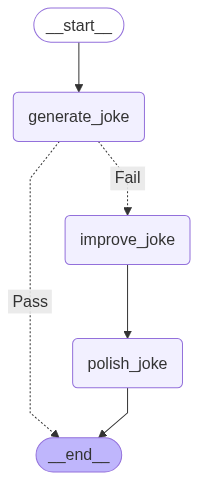

In [26]:
# Build workflow
workflow = StateGraph(State)

# Add nodes
workflow.add_node("generate_joke", generate_joke)
workflow.add_node("improve_joke", improve_joke)
workflow.add_node("polish_joke", polish_joke)

# Add edges to connect nodes
workflow.add_edge(START, "generate_joke")
workflow.add_conditional_edges("generate_joke",check_punchline,{"Fail":"improve_joke","Pass":END})
workflow.add_edge("improve_joke", "polish_joke")
workflow.add_edge("polish_joke", END)

# Compile
chain = workflow.compile()

# Show workflow
display(Image(chain.get_graph().draw_mermaid_png()))

In [27]:
state = chain.invoke({"topic":"cats"})

In [28]:
state

{'topic': 'cats',
 'joke': 'Why did the cat join a band?\n\nBecause it wanted to be the purr-cussionist!',
 'improved_joke': 'You\'ve already got a great start with "purr-cussionist"! Here\'s a revised version with some added wordplay:\n\nWhy did the cat join a band?\n\nBecause it wanted to be the purr-cussionist, and get its paws-itive feedback! It was a claw-some addition to the band, and soon they were the cat\'s meow-ite act in town!\n\nI added:\n\n* "paws-itive feedback" to play on the idea of both cat paws and positive feedback in music\n* "claw-some" to add another feline-related pun\n* "cat\'s meow-ite act" to play on the idea of the cat being the main attraction, and the phrase "the cat\'s meow or favorite thing"',
 'final_joke': "I love the additions you made! Here's a surprising twist to take it to the next level:\n\nWhy did the cat join a band?\n\nBecause it wanted to be the purr-cussionist, and get its paws-itive feedback! It was a claw-some addition to the band, and soon 

In [32]:
print(state["joke"])

Why did the cat join a band?

Because it wanted to be the purr-cussionist!


In [30]:
print(state["improved_joke"])

You've already got a great start with "purr-cussionist"! Here's a revised version with some added wordplay:

Why did the cat join a band?

Because it wanted to be the purr-cussionist, and get its paws-itive feedback! It was a claw-some addition to the band, and soon they were the cat's meow-ite act in town!

I added:

* "paws-itive feedback" to play on the idea of both cat paws and positive feedback in music
* "claw-some" to add another feline-related pun
* "cat's meow-ite act" to play on the idea of the cat being the main attraction, and the phrase "the cat's meow or favorite thing"


In [33]:
print(state["final_joke"])

I love the additions you made! Here's a surprising twist to take it to the next level:

Why did the cat join a band?

Because it wanted to be the purr-cussionist, and get its paws-itive feedback! It was a claw-some addition to the band, and soon they were the cat's meow-ite act in town! But little did anyone know, the cat was actually a time-traveling alien from the planet Meowtopia, sent to Earth to study the art of human music. And with its newfound fame, it used its purr-cussion powers to activate a mind-controlling frequency, turning the entire audience into cat-loving minions, forced to worship the feline overlords!

The twist adds a layer of absurdity and science fiction, taking it from a simple pun-filled joke to a more elaborate and humorous tale.


In [ ]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

class State(TypedDict):
    question:str
    review:str
    testcase:str
    runtest:str
    analysefailedtest:str
    givesummary:str
def coder():
    """First LLM call to generate initial Code for mentioned question"""

    msg = llm.invoke(f"Write a code asked in mentioned question {state['question']}")
    return {"question": msg.content}

SyntaxError: incomplete input (3921062062.py, line 1)

### Parallelization¶
With parallelization, LLMs work simultaneously on a task:

LLMs can sometimes work simultaneously on a task and have their outputs aggregated programmatically. This workflow, parallelization, manifests in two key variations: Sectioning: Breaking a task into independent subtasks run in parallel. Voting: Running the same task multiple times to get diverse outputs.

When to use this workflow: Parallelization is effective when the divided subtasks can be parallelized for speed, or when multiple perspectives or attempts are needed for higher confidence results. For complex tasks with multiple considerations, LLMs generally perform better when each consideration is handled by a separate LLM call, allowing focused attention on each specific aspect.
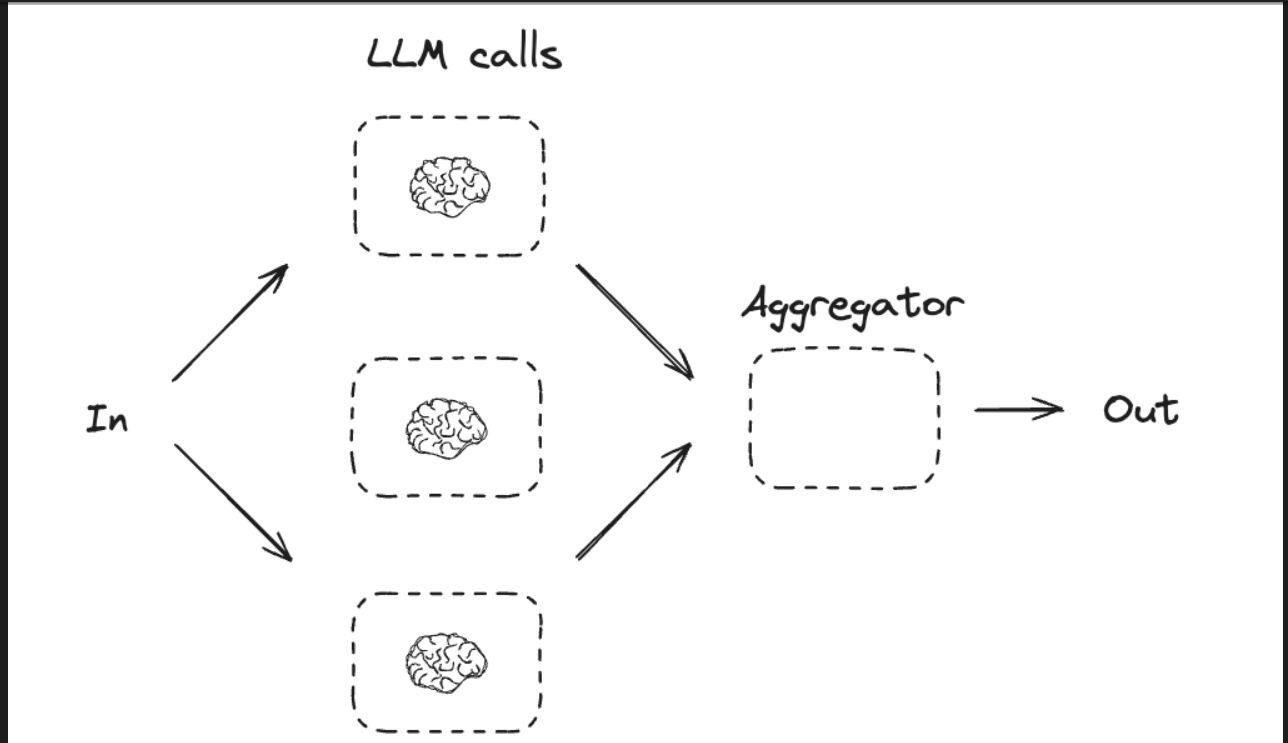